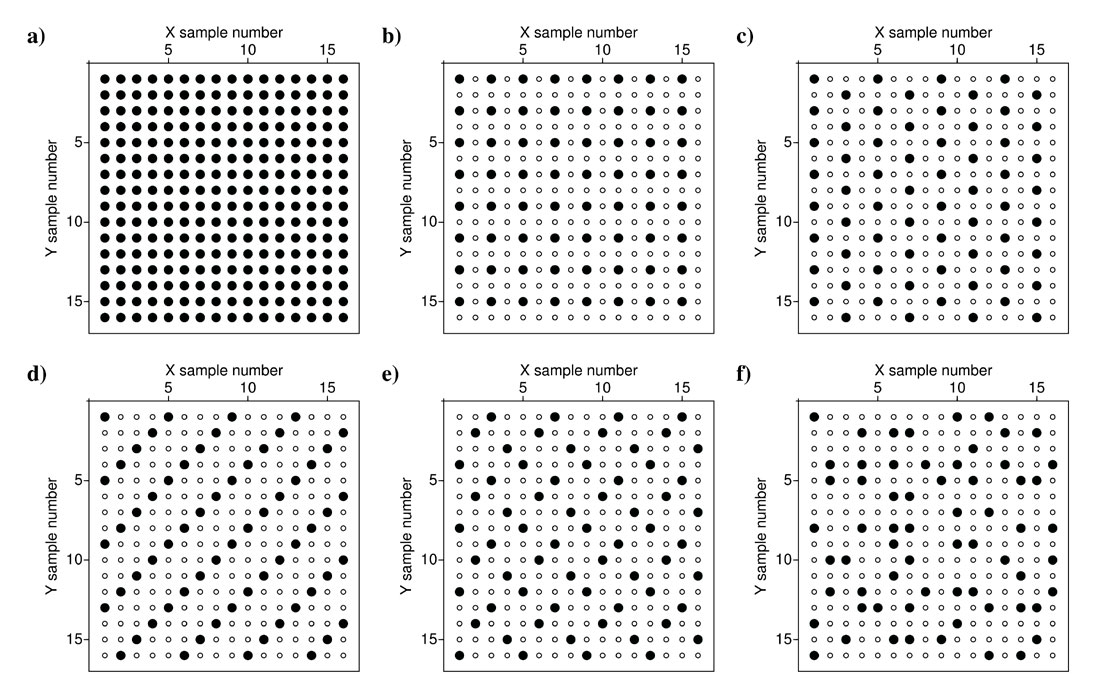

In [3]:
## Import libraries
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# URL of the image
url = "https://csegrecorder.com/assets/images/articles/2013-12-sparcity-fig01.jpg"

# Download
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display
img.show()          # Opens in external viewer
img                 # Displays inline in Jupyter


In [5]:
# ----------------------------
# simple plot helper function
# ----------------------------
def plot_mask(mask, ax=None, filled_size=60, empty_size=18):
    """
    Scatter plot that mimics the look: filled dots where sampled, hollow small circles where not.
    """
    import matplotlib.pyplot as plt
    ny, nx = mask.shape
    yy, xx = np.indices((ny, nx))
    xs, ys = xx.ravel(), yy.ravel()
    if ax is None:
        fig, ax = plt.subplots()
    # invert y for a top-left origin look similar to the figure
    ax.scatter(xs[~mask.ravel()], ys[~mask.ravel()], s=empty_size, facecolors='none', edgecolors='k', linewidths=0.6)
    ax.scatter(xs[mask.ravel()], ys[mask.ravel()], s=filled_size)
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, nx - 0.5)
    ax.set_ylim(ny - 0.5, -0.5)
    ax.set_xlabel('X sample number')
    ax.set_ylabel('Y sample number')
    return ax


In [4]:
# Panel A- generator
def pattern_a_full(nx=16, ny=16):
    """(a) Fully sampled regular grid."""
    return np.ones((ny, nx), dtype=bool)

Creates a full grid of True values (size ny × nx).

Every position is sampled (like panel a in the figure).

<Axes: xlabel='X sample number', ylabel='Y sample number'>

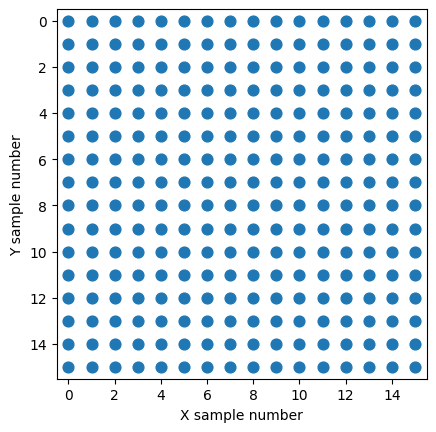

In [7]:
plot_mask(pattern_a_full(nx=16, ny=16))

In [11]:
def pattern_b_regular_decimation(nx=16, ny=16, stepx=2, stepy=2, phase_x=0, phase_y=0):
    """
    (b) Regular decimation: keep every 'step' sample in x,y with optional phase.
    Example: stepx=2, stepy=2 keeps every other trace on a checker lattice.
    """
    yy, xx = np.indices((ny, nx))
    keep_x = (xx - phase_x) % stepx == 0
    keep_y = (yy - phase_y) % stepy == 0
    return keep_x & keep_y

<Axes: xlabel='X sample number', ylabel='Y sample number'>

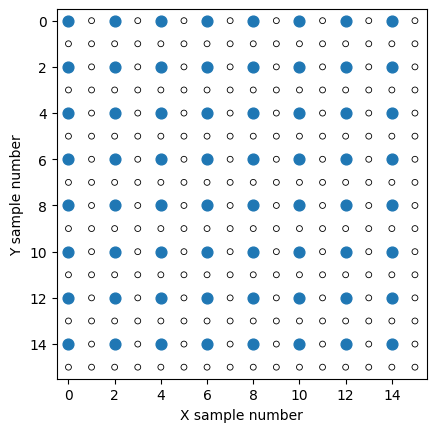

In [24]:
plot_mask(pattern_b_regular_decimation(nx=16, ny=16, stepx=2, stepy=2, phase_x=0, phase_y=0))

In [47]:
def pattern_c_phase2(nx=16, ny=16):
    """
    Panel (c): exact 2-column x-phase shift on odd rows, no y-decimation.
    Keep every 4th column on each row, but rows alternate phase by +2.
      even rows: keep x = 0,4,8,12,...
       odd rows: keep x = 2,6,10,14,...
    Density = 1/4 overall (same as 2x2 decimation).
    """
    yy, xx = np.indices((ny, nx))
    phase_x = (yy % 2) * 2
    return ((xx - phase_x) % 4) == 0

<Axes: xlabel='X sample number', ylabel='Y sample number'>

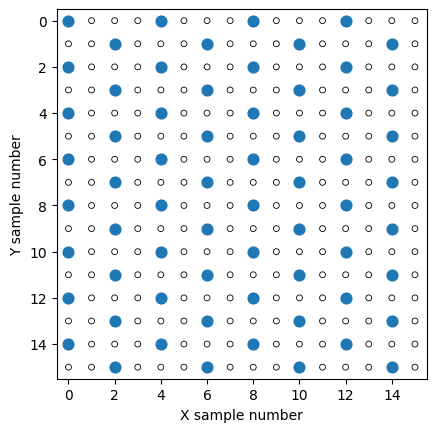

In [49]:
plot_mask(pattern_c_phase2(nx=16, ny=16))

In [54]:
def pattern_d_panel(nx=16, ny=16, step=4, offset=0):
    """
    Panel (d): keep points where (x + y) ≡ offset (mod step), using 0-based indices.
    Default offset=0
    """
    yy, xx = np.indices((ny, nx))       # 0-based indices
    return ((xx + yy - offset) % step) == 0

<Axes: xlabel='X sample number', ylabel='Y sample number'>

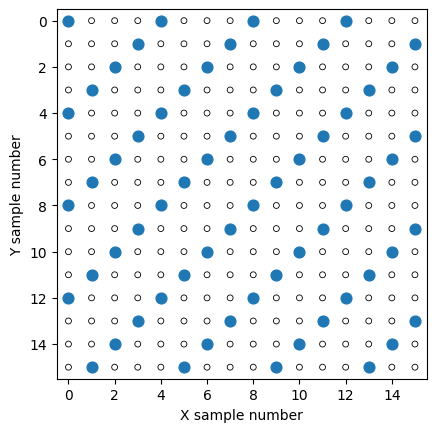

In [56]:
plot_mask(pattern_d_panel(nx=16, ny=16, step=4, offset=0))

For Panel e
- We keep the same 25% density as in (d).
- Instead of a single diagonal modulo condition, we pair rows (y, y+1).
- In each pair, the kept x indices form short diagonal pairs:
- First row of the pair uses (x, y).
- Second row of the pair uses (x±1, y+1).
- The slope alternates every other row-pair: / then \ then / etc.

In [57]:
def pattern_e_panel(nx=16, ny=16, step=4, start_offset=1):
    """
    Panel (e): derived from panel (d) by pairing rows and alternating slope.

    Rules:
      - Rows are grouped in pairs: (0,1), (2,3), (4,5), ...
      - In each pair:
          * Row y0: keep x where (x - start_offset - (y0//2)) % step == 0
          * Row y1: keep the paired neighbor at x±1, direction alternates
      - Direction alternates for successive row-pairs: right (+1), left (−1), right (+1)...
    """
    yy, xx = np.indices((ny, nx))
    mask = np.zeros((ny, nx), dtype=bool)

    # pair index across rows
    pair_index = yy // 2
    in_pair = yy % 2  # 0=first row, 1=second row in pair

    # base condition from (d): diagonal modulo
    base = ((xx - start_offset - pair_index) % step == 0)

    # direction alternates: +1 for even pairs, -1 for odd pairs
    direction = np.where(pair_index % 2 == 0, 1, -1)

    # apply offset on second row of pair
    x_shift = in_pair * direction
    shifted = ((xx - x_shift - start_offset - pair_index) % step == 0)

    mask = np.where(in_pair == 0, base, shifted)
    return mask

<Axes: xlabel='X sample number', ylabel='Y sample number'>

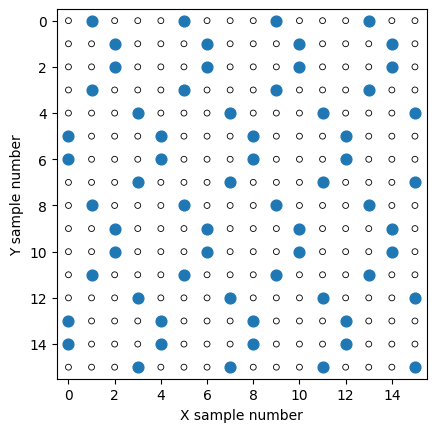

In [59]:
plot_mask(pattern_e_panel(nx=16, ny=16, step=4, start_offset=1))

-Does this look correct? If not what is the correct algorithm?
(EXTRA CREDIT: 20 points!)


In [62]:
def pattern_blue_noise(nx=16, ny=16, k=64, rng=None):
    """
    (e) Blue-noise / Poisson-disk-like discrete sampling via best-candidate.
    k = number of points to place (or ~ density * nx * ny).
    Greedy 'Mitchell best-candidate' on a grid: at each step, add the point
    that maximizes the distance to the existing set (encourages even spacing).
    """
    rng = np.random.default_rng(rng)
    total = nx * ny
    k = int(np.clip(k, 1, total))
    coords = np.array([(y, x) for y in range(ny) for x in range(nx)])

    # Start with one random point
    chosen_idx = [rng.integers(0, total)]
    chosen = coords[chosen_idx]

    # Precompute pairwise distances lazily
    def min_dist_squared(points, P):
        # return min squared distance from P to any point in 'points'
        d = (points[:,0] - P[0])**2 + (points[:,1] - P[1])**2
        return d.min()

    remaining = set(range(total))
    remaining.discard(chosen_idx[0])

    for _ in range(1, k):
        # Sample a small random subset of candidates to keep it quick
        candidates = rng.choice(list(remaining), size=min(8*nx, len(remaining)), replace=False)
        best = None
        best_score = -1.0
        for ci in candidates:
            P = coords[ci]
            score = min_dist_squared(chosen, P)
            if score > best_score:
                best_score = score
                best = ci
        chosen_idx.append(best)
        chosen = np.vstack([chosen, coords[best]])
        remaining.discard(best)

    mask = np.zeros((ny, nx), dtype=bool)
    for (y, x) in chosen:
        mask[y, x] = True
    return mask



<Axes: xlabel='X sample number', ylabel='Y sample number'>

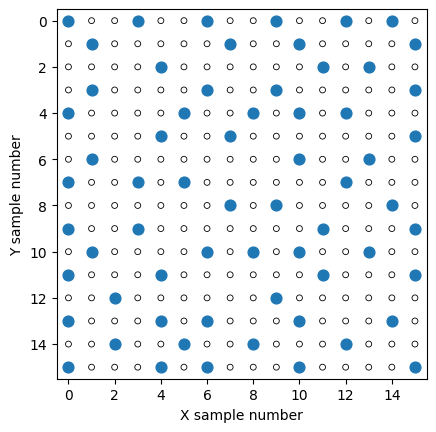

In [63]:
plot_mask(pattern_blue_noise(nx=16, ny=16, k=64, rng=None))

In [66]:
def pattern_clustered(nx=16, ny=16, density=0.25, n_clusters=5, spread=1.5, rng=None):
    """
    (f) Clustered random sampling: draw a few cluster centers, then sample
    around them with Gaussian falloff; threshold to reach target density.
    """
    rng = np.random.default_rng(rng)
    yy, xx = np.indices((ny, nx))
    prob = np.zeros((ny, nx), dtype=float)

    # Random cluster centers in continuous coords
    centers = np.column_stack([
        rng.uniform(0, ny, size=n_clusters),
        rng.uniform(0, nx, size=n_clusters)
    ])

    for cy, cx in centers:
        prob += np.exp(-((yy - cy)**2 + (xx - cx)**2) / (2 * spread**2))

    # Normalize and choose threshold for desired density
    prob = prob / prob.max()
    # Find a cutoff that yields ~density
    flat = np.sort(prob.ravel())
    cutoff = flat[int((1.0 - density) * flat.size)]
    return prob >= cutoff

<Axes: xlabel='X sample number', ylabel='Y sample number'>

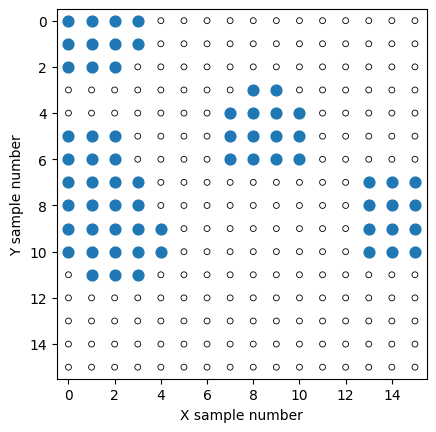

In [67]:
plot_mask(pattern_clustered(nx=16, ny=16, density=0.25))